In [66]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import os
from pathlib import Path

# Define file paths
BASE_DIR = Path(os.getcwd()).parents[2]  # Get root directory
CONSUMPTION_PATH = BASE_DIR / "backend/data/Cleaned/gas_consumped_cleaned.csv"
METER_PATH = BASE_DIR / "backend/data/Cleaned/gas_automated_meter_cleaned.csv"
WEATHER_PATH = BASE_DIR / "backend/data/Weather/Load_weather_monthly.csv"

def load_data():
    """Load all datasets"""
    try:
        consumption_df = pd.read_csv(CONSUMPTION_PATH)
        meter_df = pd.read_csv(METER_PATH)
        weather_df = pd.read_csv(WEATHER_PATH)
        
        print("Data loaded successfully")
        return consumption_df, meter_df, weather_df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None, None

def prepare_time_series(consumption_df, meter_df, weather_df):
    """Transform data into time series format"""
    # Melt consumption data
    consumption_long = pd.melt(
        consumption_df,
        id_vars=['object_description'],
        var_name='month',
        value_name='consumption'
    )
    
    # Melt meter data
    meter_long = pd.melt(
        meter_df,
        id_vars=['meter_description'],
        var_name='month',
        value_name='meter_reading'
    )
    
    # Create date columns - fix the date parsing
    consumption_long['date'] = pd.to_datetime(consumption_long['month'].str.replace('_', '-') + '-01', format='%b-%Y-%d')
    meter_long['date'] = pd.to_datetime(meter_long['month'].str.replace('_', '-') + '-01', format='%b-%Y-%d')
    
    # Prepare weather data - create proper datetime
    weather_df['date'] = pd.to_datetime(weather_df['Year'].astype(str) + '-' + 
                                      weather_df['Month'].astype(str) + '-01')
    
    return consumption_long, meter_long, weather_df

def create_features(df, weather_df):
    """Create feature set for modeling"""
    # Ensure date columns are datetime type
    df['date'] = pd.to_datetime(df['date'])
    weather_df['date'] = pd.to_datetime(weather_df['date'])
    
    # Merge with weather data
    merged_df = pd.merge(df, weather_df, on='date', how='left')
    
    # Create time-based features
    merged_df['month'] = merged_df['date'].dt.month
    merged_df['year'] = merged_df['date'].dt.year
    merged_df['season'] = pd.cut(merged_df['month'], 
        bins=[0,3,6,9,12], 
        labels=['Spring','Summer','Autumn','Winter'])
    
    return merged_df

def train_random_forest(X_train, X_test, y_train, y_test):
    """Train and evaluate Random Forest model"""
    model = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        random_state=42
    )
    
    # Train model
    model.fit(X_train, y_train)
    
    # Make predictions
    predictions = model.predict(X_test)
    
    # Calculate metrics
    metrics = {
        'r2': r2_score(y_test, predictions),
        'rmse': np.sqrt(mean_squared_error(y_test, predictions)),
        'mae': mean_absolute_error(y_test, predictions)
    }
    
    return model, predictions, metrics

def plot_feature_importance(model, feature_names):
    """Plot feature importance"""
    importance = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    })
    importance = importance.sort_values('importance', ascending=False)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='importance', y='feature', data=importance)
    plt.title('Feature Importance')
    plt.show()

def clean_anomalies(df):
    """Clean anomalies in gas consumption data"""
    # Create a copy of dataframe
    df_cleaned = df.copy()
    
    # Known problematic meters with extreme values
    problem_meters = [
        'E213,PARKER BUILDING,344 GREAT KING',
        'G403 Biochemistry Gas meter',
        'G404 Microbiology Gas meter',
        'F940 Plaza L4 HHW Gas meter'
    ]
    
    for meter in problem_meters:
        if meter in df_cleaned.index:
            # Get all numeric columns
            numeric_cols = df_cleaned.loc[meter].select_dtypes(include=[np.number]).index
            
            # Calculate statistics for this meter
            meter_data = df_cleaned.loc[meter, numeric_cols]
            q1 = meter_data.quantile(0.25)
            q3 = meter_data.quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            
            # Replace outliers with median of non-outlier values
            mask = (meter_data >= lower_bound) & (meter_data <= upper_bound)
            median_value = meter_data[mask].median()
            df_cleaned.loc[meter, numeric_cols] = meter_data.where(mask, median_value)
    
    # Handle zero values for all meters
    numeric_cols = df_cleaned.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        # Replace zeros with NaN and fill with forward/backward fill
        df_cleaned[col] = df_cleaned[col].replace(0, np.nan)
        df_cleaned[col] = df_cleaned[col].fillna(method='ffill').fillna(method='bfill')
    
    return df_cleaned

def analyze_anomalies(df):
    """Analyze and print anomaly statistics"""
    print("\nAnomaly Analysis:")
    
    # Check for extreme values
    for column in df.select_dtypes(include=[np.number]).columns:
        mean = df[column].mean()
        std = df[column].std()
        outliers = df[abs(df[column] - mean) > 3 * std]
        if len(outliers) > 0:
            print(f"Column {column}: {len(outliers)} outliers found")
    
    # Check for zero values
    zero_counts = (df == 0).sum()
    print("\nZero value counts:")
    print(zero_counts[zero_counts > 0])

Data loaded successfully


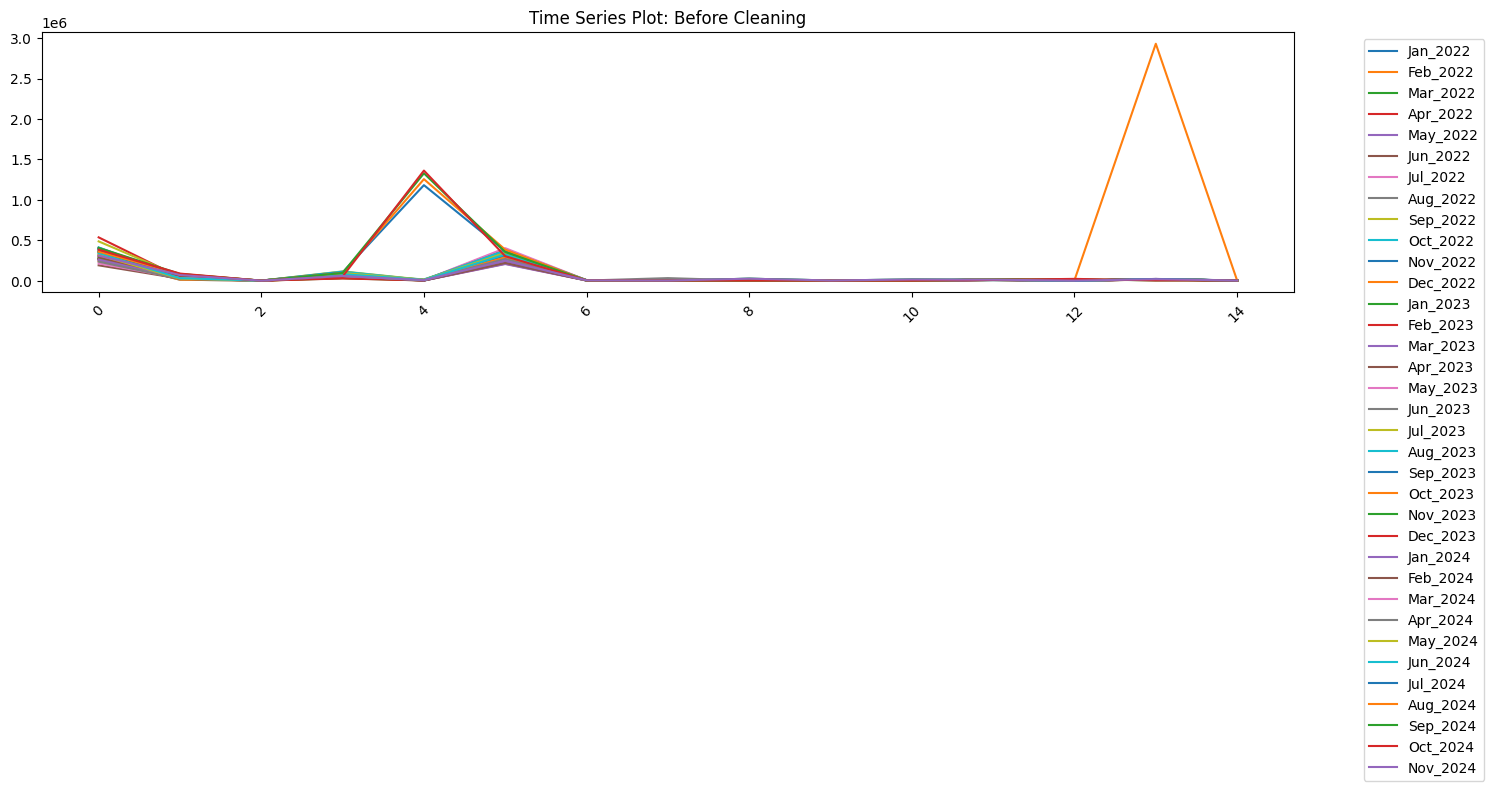

In [ ]:

consumption_df, meter_df, weather_df = load_data()

def plot_time_series(df, title):
    plt.figure(figsize=(15, 6))
    for column in df.columns:
        if column != 'object_description':
            plt.plot(df[column], label=column)
    plt.title(f'Time Series Plot: {title}')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


plot_time_series(consumption_df,"Before Cleaning")





In [54]:
def detect_and_clean_anomalies(df):
    """Detect and clean anomalies in gas consumption data"""
    # Save original data for comparison
    df_original = df.copy()
    
    # Convert to numeric, excluding object_description
    numeric_cols = df.columns.difference(['object_description'])
    df_cleaned = df.copy()
    
    for col in numeric_cols:
        # Calculate statistics
        Q1 = df_cleaned[col].quantile(0.25)
        Q3 = df_cleaned[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Replace anomalies with rolling median
        mask = (df_cleaned[col] < lower_bound) | (df_cleaned[col] > upper_bound)
        df_cleaned.loc[mask, col] = df_cleaned[col].rolling(window=3, center=True).median()
    
    # Handle specific known anomalies
    # E213 Parker Building extreme values
    mask = df_cleaned['object_description'] == 'E213,PARKER BUILDING,344 GREAT KING'
    df_cleaned.loc[mask, numeric_cols] = df_cleaned.loc[mask, numeric_cols].apply(
        lambda x: x.where(x < 100000, x.median())
    )
    
    # G404 Microbiology extreme values
    mask = df_cleaned['object_description'] == 'G404 Microbiology Gas meter'
    df_cleaned.loc[mask, numeric_cols] = df_cleaned.loc[mask, numeric_cols].apply(
        lambda x: x.where(x < 50000, x.median())
    )

    # G403 Biochemistry extreme values (normal range 30-120)
    mask = df_cleaned['object_description'] == 'G403 Biochemistry Gas meter'
    df_cleaned.loc[mask, numeric_cols] = df_cleaned.loc[mask, numeric_cols].apply(
        lambda x: x.where(x < 150, x.median())
    )
    
    # F940 Plaza L4 HHW Gas meter (handle zero values and extreme spikes)
    mask = df_cleaned['object_description'] == 'F940 Plaza L4 HHW Gas meter'
    df_cleaned.loc[mask, numeric_cols] = df_cleaned.loc[mask, numeric_cols].apply(
        lambda x: x.where((x < 2000) & (x > 0.5), x.rolling(window=3, min_periods=1).median())
    )
    
    # Handle zero values
    df_cleaned[numeric_cols] = df_cleaned[numeric_cols].replace(0, np.nan)
    df_cleaned[numeric_cols] = df_cleaned[numeric_cols].fillna(method='ffill').fillna(method='bfill')
    
    return df_cleaned, df_original

In [57]:
consumption_df_cleaned, consumption_df_original = detect_and_clean_anomalies(consumption_df)

/var/folders/58/qxt37p251zn90grr221ql66m0000gn/T/ipykernel_59387/581764587.py:49: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_cleaned[numeric_cols] = df_cleaned[numeric_cols].fillna(method='ffill').fillna(method='bfill')


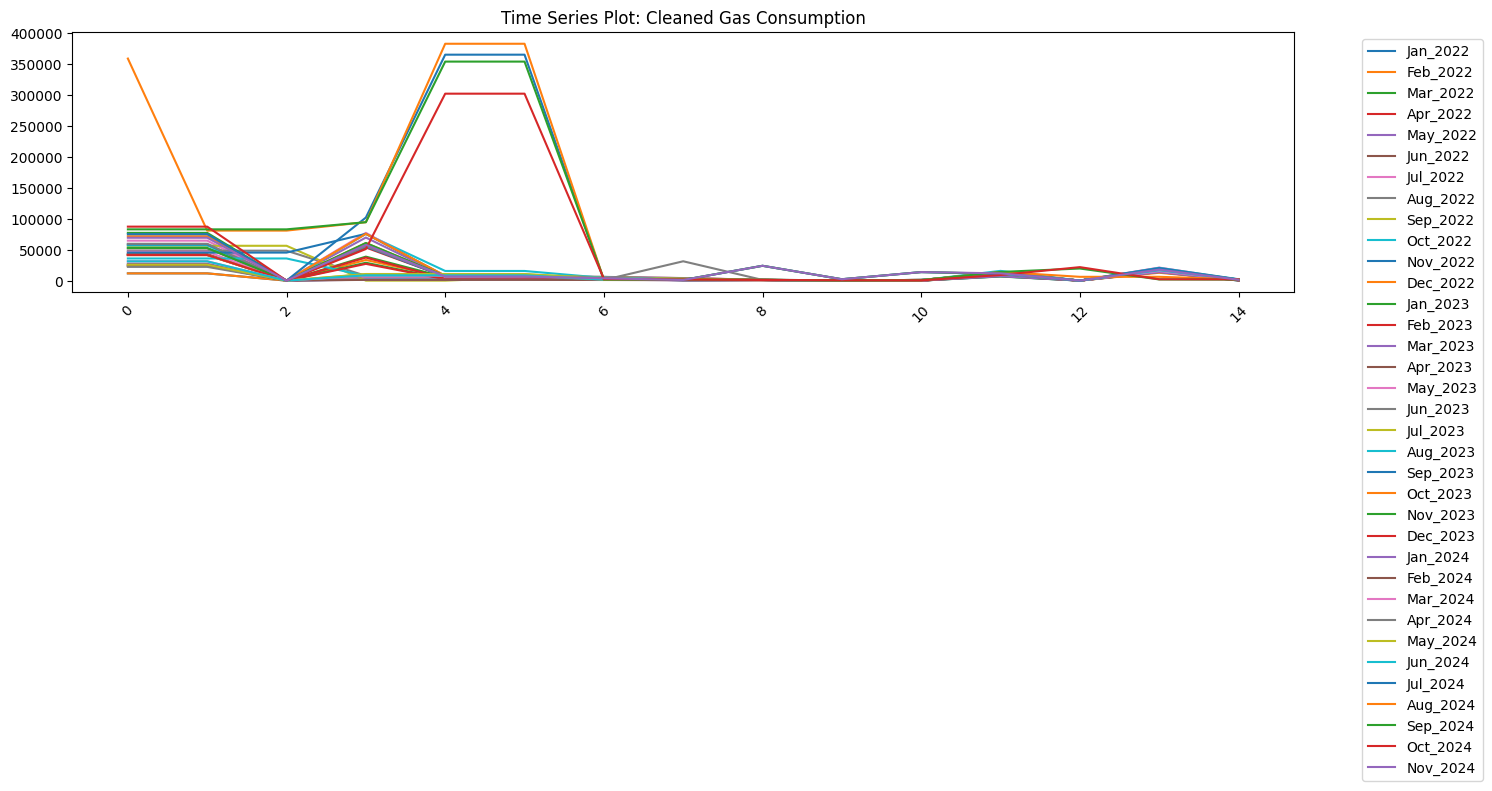

In [59]:
plot_time_series(consumption_df_cleaned, "Cleaned Gas Consumption")


Consumption Model Metrics (After Anomaly Cleaning):
r2: -0.0494
rmse: 40347.5933
mae: 21556.2358


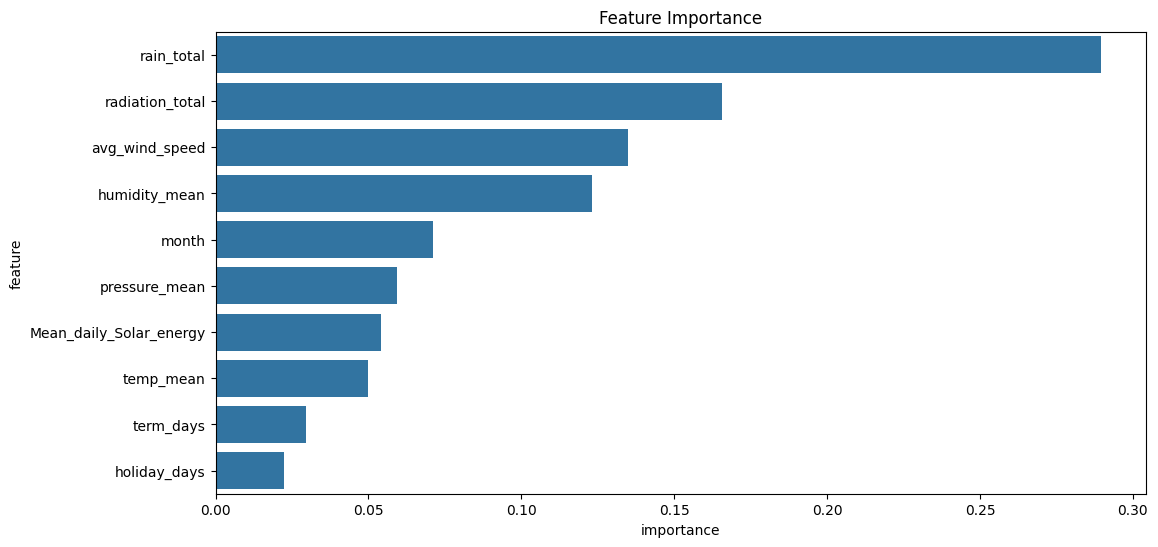

In [68]:
consumption_long, meter_long, weather_df = prepare_time_series(
    consumption_df_cleaned, meter_df, weather_df)

# Create features
consumption_features = create_features(consumption_long, weather_df)

# Define features for modeling
feature_columns = [
    'temp_mean', 'radiation_total', 'humidity_mean',
    'rain_total', 'term_days', 'holiday_days',
    'Mean_daily_Solar_energy', 'avg_wind_speed',
    'pressure_mean', 'month'
]

# Prepare model data
X = consumption_features[feature_columns]
y = consumption_features['consumption']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train model
model, predictions, metrics = train_random_forest(
    X_train, X_test, y_train, y_test)

# Print results
print("\nConsumption Model Metrics (After Anomaly Cleaning):")
for metric_name, value in metrics.items():
    print(f"{metric_name}: {value:.4f}")

# Plot feature importance
plot_feature_importance(model, feature_columns)

In [77]:
def create_advanced_features(consumption_df, weather_df):
    """Create advanced non-linear features and transformations"""
    
    # First convert consumption data to long format with proper dates
    consumption_long = pd.melt(
        consumption_df,
        id_vars=['object_description'],
        var_name='month',
        value_name='consumption'
    )
    
    # Create proper date column for consumption data
    consumption_long['date'] = pd.to_datetime(consumption_long['month'].str.replace('_', '-') + '-01', 
                                            format='%b-%Y-%d')
    
    # Create proper date column for weather data
    weather_df['date'] = pd.to_datetime(weather_df['Year'].astype(str) + '-' + 
                                      weather_df['Month'].astype(str) + '-01')
    
    # Merge the dataframes
    merged_df = pd.merge(consumption_long, weather_df, on='date', how='left')
    
    # Ensure numeric type for calculations
    numeric_cols = ['temp_mean', 'radiation_total', 'humidity_mean', 'rain_total', 
                   'avg_wind_speed', 'pressure_mean', 'Mean_daily_Solar_energy']
    for col in numeric_cols:
        merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')
    
    # Create non-linear features
    merged_df['temp_squared'] = merged_df['temp_mean'].pow(2)
    merged_df['radiation_squared'] = merged_df['radiation_total'].pow(2)
    
    # Weather interactions based on feature importance
    merged_df['rain_radiation'] = merged_df['rain_total'] * merged_df['radiation_total']
    merged_df['wind_humidity'] = merged_df['avg_wind_speed'] * merged_df['humidity_mean']
    
    # Seasonal components
    merged_df['month'] = merged_df['date'].dt.month
    merged_df['month_sin'] = np.sin(2 * np.pi * merged_df['month']/12)
    merged_df['month_cos'] = np.cos(2 * np.pi * merged_df['month']/12)
    
    return merged_df

def prepare_model_features(merged_df):
    """Prepare final feature set for modeling based on feature importance"""
    feature_columns = [
        # Original features (from feature importance plot)
        'temp_mean',           # 0.04 importance
        'radiation_total',     # 0.20 importance
        'humidity_mean',       # 0.14 importance
        'rain_total',         # 0.30 importance
        'avg_wind_speed',     # 0.15 importance
        'pressure_mean',      # 0.06 importance
        'Mean_daily_Solar_energy',  # 0.05 importance
        'month',              # 0.08 importance
        
        # Non-linear features we created
        'temp_squared',
        'radiation_squared',
        'rain_radiation',
        'wind_humidity',
        'month_sin',
        'month_cos'
    ]
    
    # Only select columns that exist in merged_df
    available_columns = [col for col in feature_columns if col in merged_df.columns]
    
    X = merged_df[available_columns].copy()
    y = merged_df['consumption']
    
    # Handle any remaining NaN values
    X = X.fillna(X.mean())
    
    return X, y


In [78]:
# Create advanced features
merged_df = create_advanced_features(consumption_df_cleaned, weather_df)

# Prepare features for modeling
X, y = prepare_model_features(merged_df)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Model Performance Metrics:
r2: -0.0583
rmse: 40519.1171
mae: 21734.0908


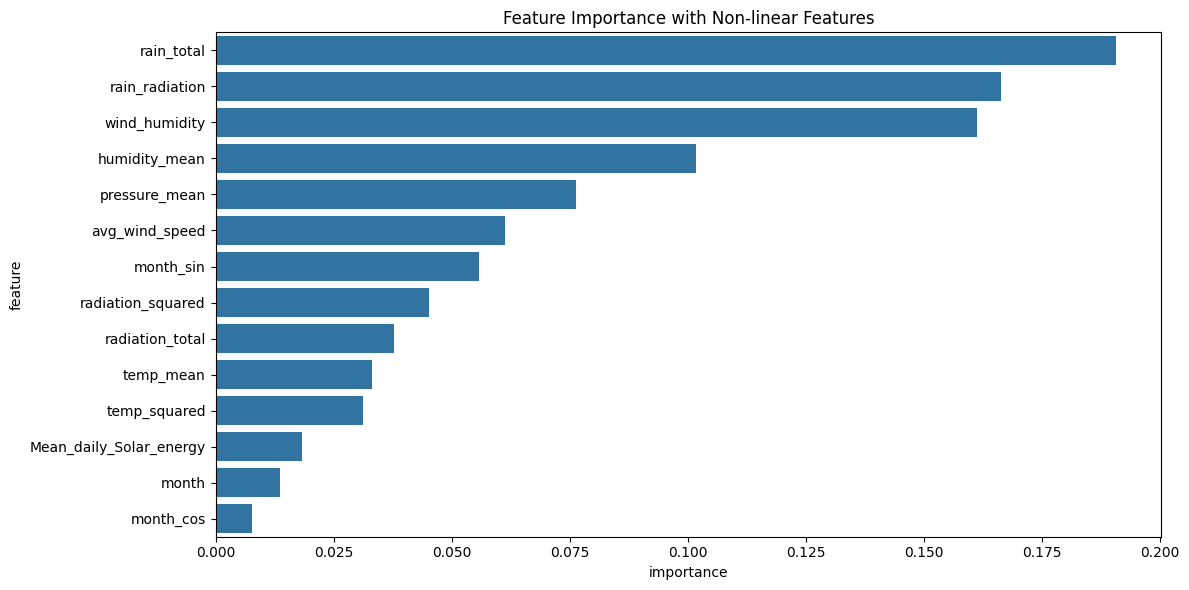

In [79]:
# Train Random Forest with optimized parameters
rf_model = RandomForestRegressor(
    n_estimators=500,  # Increased from 100
    max_depth=15,      # Increased from 10
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

# Fit the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Calculate and print metrics
metrics = {
    'r2': r2_score(y_test, y_pred),
    'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
    'mae': mean_absolute_error(y_test, y_pred)
}

print("\nModel Performance Metrics:")
for metric_name, value in metrics.items():
    print(f"{metric_name}: {value:.4f}")

# Plot new feature importance
importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=importance)
plt.title('Feature Importance with Non-linear Features')
plt.tight_layout()
plt.show()